In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import rasterio
import os
import glob
import warnings
import random
import numpy as np

# Suppress runtime warnings
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide")

# **Example Code**
Example code that, given a plot record ID corresponding to the position of that plot in the train_HIPS_HYBRIDS_2023_V2.3.csv data file, retrieves and displays relative paths to all images collected from that plot, calculates multiple values for those images, displays ground truth data collected from that plot, and displays an example satellite image from that plot.

In [24]:
##Functions for visualizing images and getting data


def norm(band):
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))


##Function for calculating indices in satellite image by removing the border pixels which is 0

def satelliteimage(inputpath):
    color=[]
    with rasterio.open(inputpath, 'r') as src:
        # print(src.shape)
        S_images=src.read()
        b2 = norm(S_images[0].astype(np.float32))
        b3 = norm(S_images[1].astype(np.float32))
        b4 = norm(S_images[2].astype(np.float32))

        # Create RGB
        rgb = np.dstack((b4,b3,b2))

        # Visualize RGB

        plt.imshow(rgb)
        plt.axis('off')

        h=src.height
        w=src.width 

        Image=os.path.basename(inputpath)
        count=0
        for height in range(h):
            for width in range(w):
                r,g,b,nir,re,db=src.read(1)[height,width],src.read(2)[height,width],src.read(3)[height,width],src.read(4)[height,width],src.read(5)[height,width],src.read(6)[height,width]

                GLI=(2*g-r-b)/(2*g+r+b)

                # GRVIupper=g.astype(float)-r.astype(float)
                # GRVIlower=g.astype(float)+r.astype(float)
                # GRVI=(GRVIupper.astype(float)/GRVIlower.astype(float))

                NGRDIupper=r.astype(float)-g.astype(float)
                NGRDIlower=g.astype(float)+r.astype(float)
                NGRDI=(NGRDIupper.astype(float)/NGRDIlower.astype(float))

                NDVIupper=nir.astype(float)-r.astype(float)
                NDVIlower=nir.astype(float)+r.astype(float)
                NDVI=(NDVIupper.astype(float)/NDVIlower.astype(float))

                GNDVIupper=nir.astype(float)-g.astype(float)
                GNDVIlower=nir.astype(float)+g.astype(float)
                GNDVI=(GNDVIupper.astype(float)/GNDVIlower.astype(float))

                SAVIupper=1.5*(nir.astype(float)-r.astype(float))
                SAVIlower=nir.astype(float)+r.astype(float)+0.5
                SAVI=(SAVIupper.astype(float)/SAVIlower.astype(float))

                NDREupper=nir.astype(float)-re.astype(float)
                NDRElower=nir.astype(float)+re.astype(float)
                NDRE=(NDREupper.astype(float)/NDRElower.astype(float))

                color.append(
                    {'Imagename':Image,
                     'Red':r,
                     'Green':g,
                     'Blue':b,
                     'GLI':GLI,
                     # 'GRVI':GRVI,
                     'NGRDI':NGRDI,
                     'NDVI':NDVI,
                     'GNDVI':GNDVI,
                     'SAVI':SAVI,
                     'NDRE':NDRE,
                     'RedEdge':re,
                     'DeepBlue':db,
                     'Nir':nir
                    } 
                )
    band_values=pd.DataFrame(color)
    band_values=band_values[band_values['Red']>0] ##Remove the pixel values that is equal to zero
    band_values=band_values.groupby('Imagename')[list(band_values.describe().columns)].agg(['mean', 'median', 'sum']).reset_index()
    band_values.columns = band_values.columns.map('_'.join)
    
    return band_values.loc[0]



##Functopn for calculating indices for RGB images

def RGB(inputpath):
    color=[]
    img=cv.imread(inputpath)
    img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
    h=img.shape[0]
    w=img.shape[1]
    Image=os.path.basename(inputpath)
    plt.imshow(img)
    plt.axis('off')
    for height in range(h):
        # print(height)
        for width in range(w):
            # print(height, width)
            r,g,b = img[height, width]
            GLI=(2*g-r-b)/(2*g+r+b)


            NGRDIupper=r.astype(float)-g.astype(float)
            NGRDIlower=g.astype(float)+r.astype(float)
            NGRDI=(NGRDIupper.astype(float)/NGRDIlower.astype(float))

            # GRVIupper=g.astype(float)-r.astype(float)
            # GRVIlower=g.astype(float)+r.astype(float)
            # GRVI=(GRVIupper.astype(float)/GRVIlower.astype(float))
            # print(r,g,b,GLI,NGRDI)
#                 print(type(r),type(g),type(b),type(GLI),type(NGRDI))


            color.append(
                {'Imagename':Image,
                 'Red':r,
                 'Green':g,
                 'Blue':b,
                 'GLI':GLI,
                 'NGRDI':NGRDI,
                 # 'GRVI':GRVI
                }
            )
    RGB_values=pd.DataFrame(color)
    RGB_values=RGB_values[RGB_values['Red']>0] ##Remove the pixel values that is equal to zero
    RGB_values=RGB_values.groupby('Imagename')[list(RGB_values.describe().columns)].agg(['mean', 'median', 'sum']).reset_index()
    RGB_values.columns = RGB_values.columns.map('_'.join)
    return RGB_values.loc[0]

In [25]:
path_to_files=os.listdir('../')
paths_to_image_files=[os.path.join('../',x) for x in path_to_files if x=='Satellite' or x=='UAV']
image_path_location=[os.listdir(x) for x in paths_to_image_files]

print(image_path_location,paths_to_image_files)
data=pd.read_csv('../GroundTruth/train_HIPS_HYBRIDS_2023_V2.3.csv')
Date=pd.read_excel('../GroundTruth/DateofCollection.xlsx')

Rownumber=int(input(f'The dataframe has total {data.shape[0]} number of plots. Enter the number between 0 and {data.shape[0]}:'))

location=data.loc[Rownumber]['location']
row=data.loc[Rownumber]['row']
rangeno=data.loc[Rownumber]['range']
experiment=data.loc[Rownumber]['experiment']
genotype=data.loc[Rownumber]['genotype']
groundtruth=data.loc[Rownumber][13:].to_string(index=True)

print('\n')
print('if NaN, it means we have no data.')
print('\n')
print(f'The experimental plot with genotype name {genotype} was at: {location} grown with experimental code in column "experiment" in dataframe: {experiment} in range {rangeno} and row {row}. The ground truth data available are:')

print('\n')
print(groundtruth)
print('\n')
print('Image file names belonging to the plot and their relative paths are:')


Final_path=[]

for files in image_path_location[0]:
    if not files==location:
        continue
    finallocation=location
    finalimagefolder=[os.path.join(x,finallocation) for x in paths_to_image_files]
    # print(finalimagefolder)4
    
for locationfolder in finalimagefolder:
    
    timepointfolder=os.listdir(locationfolder)
    timepointfolder=sorted(timepointfolder)
    imagetype=locationfolder.split('/')[1]
    print(imagetype)
    
    timepointpath=[os.path.join(locationfolder,x) for x in timepointfolder]
    
    for timepointpath_ in timepointpath:
        
        imagefiles=os.listdir(timepointpath_)
        
        for images in imagefiles:
            range_=images.split('_')[1]
            row_=images.split('_')[2].split('.')[0]
            experiment_=images.split('_')[0].split('-')[2]
            
            # print(range_, row_,experiment_)
            # print(rangeno, row, experiment)
            if str(range_)==str(rangeno) and str(row_)==str(row) and str(experiment)==str(experiment_):
       
                timepoint=images.split('_')[0].split('-')[1]
                
                date_=Date.loc[(Date['Location']==location) & (Date['Image']==imagetype) & (Date['time']==timepoint)]['Date'].to_string(index=False)
                finalpath=os.path.join(timepointpath_,images)
                print(f'{finalpath}, Timepoint of image {timepoint} = {date_}')
                
                Final_path.append(finalpath)

                

[['Lincoln', 'MOValley']] ['../Satellite']


if NaN, it means we have no data.


The experimental plot with genotype name PHP02 X PHJ89 was at: MOValley grown with experimental code in column "experiment" in dataframe: 2125 in range 13 and row 4. The ground truth data available are:


totalStandCount       NaN
daysToAnthesis        NaN
GDDToAnthesis         NaN
yieldPerAcre       141.37


Image file names belonging to the plot and their relative paths are:
Satellite
../Satellite/MOValley/TP1/MOValley-TP1-2125_13_4.TIF, Timepoint of image TP1 = 2023-07-20
../Satellite/MOValley/TP2/MOValley-TP2-2125_13_4.TIF, Timepoint of image TP2 = 2023-08-18
../Satellite/MOValley/TP3/MOValley-TP3-2125_13_4.TIF, Timepoint of image TP3 = 2023-09-07
../Satellite/MOValley/TP4/MOValley-TP4-2125_13_4.TIF, Timepoint of image TP4 = 2023-09-18


Imagename_         MOValley-TP4-2125_13_4.TIF
Red_mean                          1118.458937
Red_median                             1138.0
Red_sum                                231521
Green_mean                         832.531401
Green_median                            841.0
Green_sum                              172334
Blue_mean                          664.164251
Blue_median                             670.0
Blue_sum                               137482
GLI_mean                             -0.03185
GLI_median                          -0.034903
GLI_sum                             -6.593051
NGRDI_mean                           0.141531
NGRDI_median                         0.147794
NGRDI_sum                           29.296935
NDVI_mean                            0.320919
NDVI_median                          0.317455
NDVI_sum                            66.430271
GNDVI_mean                           0.442446
GNDVI_median                         0.442989
GNDVI_sum                         

/var/folders/xm/rfyv5lwx1bjbc0nqp6ck2zy40000gn/T/ipykernel_11786/1848844637.py:37: RuntimeWarning: invalid value encountered in long_scalars
  GLI=(2*g-r-b)/(2*g+r+b)
/var/folders/xm/rfyv5lwx1bjbc0nqp6ck2zy40000gn/T/ipykernel_11786/1848844637.py:45: RuntimeWarning: invalid value encountered in double_scalars
  NGRDI=(NGRDIupper.astype(float)/NGRDIlower.astype(float))
/var/folders/xm/rfyv5lwx1bjbc0nqp6ck2zy40000gn/T/ipykernel_11786/1848844637.py:49: RuntimeWarning: invalid value encountered in double_scalars
  NDVI=(NDVIupper.astype(float)/NDVIlower.astype(float))
/var/folders/xm/rfyv5lwx1bjbc0nqp6ck2zy40000gn/T/ipykernel_11786/1848844637.py:53: RuntimeWarning: invalid value encountered in double_scalars
  GNDVI=(GNDVIupper.astype(float)/GNDVIlower.astype(float))
/var/folders/xm/rfyv5lwx1bjbc0nqp6ck2zy40000gn/T/ipykernel_11786/1848844637.py:61: RuntimeWarning: invalid value encountered in double_scalars
  NDRE=(NDREupper.astype(float)/NDRElower.astype(float))


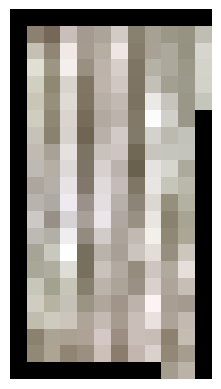

In [26]:
##Show one random satellite image from the row that you selected in above code

satfile=random.choice(Final_path[0:6])
basefile=os.path.basename(satfile)

if basefile.endswith('.TIF'):
    Value=satelliteimage(satfile).to_string()
    print(Value)